In [54]:
import os
os.chdir('../quafing/')
print(os.getcwd())


import quafing as q
import numpy as np
import pickle
import random
import math


import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(8,6)})


from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import LabelEncoder


from astropy.stats import bayesian_blocks

import pandas as pd
pd.options.mode.chained_assignment = None

/Users/charlesdupont/Desktop/Thesis/code/quafing


In [2]:
DATA_DIR    = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [3]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def get_processed_df(results):
    processed = pd.DataFrame.from_dict({})
    for column in results[1]:
        processed[column] = [results[hhid][column] for hhid in results]
    return processed


def chunks(l, n):
    L = len(l)
    num_groups = math.floor(L/n)
    end_chunk = l[int(num_groups*n):]
    l = l[:int(num_groups*n)]
    
    groups = []
    for i in range(0, len(l), n):
        groups.append(l[i:i + n])
    
    for i, item in enumerate(end_chunk):
        groups[i].append(item)
    
    return groups


def FINE(rawdata, variable_types, replace_missing=False, d=2, random_grouping=False, plot=False):  
    
    # check in case of systemic non-response for specific communities
    grouped = rawdata.groupby("community_code")
    missing_prop = {}

    for col in rawdata.columns:
        unique = grouped[col].unique()
        count = 0
        communities = set()
        idx = unique.index
        for i, item in enumerate(unique):
            if len(item) == 1 and item[0] == -1:
                print(col)
                break
                
    if random_grouping:
        rawdata = rawdata.drop(["community_code"], axis=1)
        rawdata = rawdata.reset_index(drop=True)
        idx = list(rawdata.index)
        random.shuffle(idx)
        random_groups = list(chunks(idx, 20))

        group_label = {}
        for i,g in enumerate(random_groups):
            for item in g:
                group_label[item]=i

        random_group_col = []
        rawdata = rawdata.reset_index(drop=True)
        for index, _ in rawdata.iterrows():
            random_group_col.append(group_label[index])
            
        rawdata["group_col"] = random_group_col
        group_col = "group_col"

    else:
        group_col = "community_code"
                
    # assign column types and grouping column(s)
    col_types = []
    for col in rawdata.columns:
        if col == group_col:
            col_types.append("g")
        elif variable_types[col] == "binary":
            col_types.append("b")
        elif variable_types[col] == "discrete_categorical":
            col_types.append("u")
        elif variable_types[col] in ["continuous", "discrete_ordered"]:
            col_types.append("o")


    rawmetadata = {
        "ColNames": np.array(rawdata.columns),
        "ColTypes": np.array(col_types),
        "QuestionNumbers": np.array([i for i in range(1, len(rawdata.columns)+1)])
    }
    

    if replace_missing:
        # replace missing values with uniformly selected choice from options
        for c in rawdata.columns:
            options = [x for x in rawdata[c].unique() if x!=-1]
            vals = list(rawdata[c])
            for i, v in enumerate(vals):
                if v == -1:
                    vals[i] = np.random.choice(options)
            rawdata[c] = vals
            
    prep = q.PreProcessor(rawdata, rawmetadata)
    prep.select_columns(select_all=True)
    prep.set_cont_disc()
    prep.set_density_method(method='Discrete1D', cols=['o','u','b'])
    prep.split_to_groups(group_col)
    
    mdpdfcol = q.create_mdpdf_collection('factorized', prep._groups, prep._grouplabels, prep._groupcolmetadata,)
    mdpdfcol.calculate_distance_matrix(method='hellinger', pwdist='rms')
    mdpdfcol.calculate_shortest_path_matrix()
    
    embedder = q.get_embedder('mds', mdpdfcol)
    embedding = embedder.embed(dimension=d, return_all=True)
    
    if plot:
        q.plot_embedding(embedding, mdpdfcol)
    
    return embedding["embedding"]

In [4]:
EMBEDDINGS = {}

# 1) Handpicked features

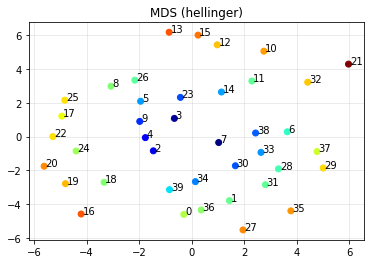

In [5]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features_handpicked.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types_handpicked.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)

emb_handpicked = FINE(rawdata, variable_types, plot=True)
EMBEDDINGS["Handpicked Features"] = emb_handpicked

# 2) Handpicked features (random grouping)

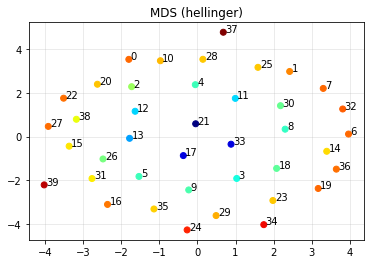

In [6]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features_handpicked.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types_handpicked.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)

emb_mi = FINE(rawdata, variable_types, random_grouping=True, plot=True)
EMBEDDINGS["Handpicked Features\n(Random Grouping)"] = emb_mi

# 3) MI features

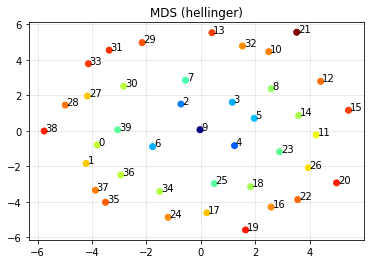

In [7]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features_mi.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types_mi.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)
    
emb_mi = FINE(rawdata, variable_types, plot=True)
EMBEDDINGS["Mutual Information Features"] = emb_mi

# 4) MI features (random grouping)

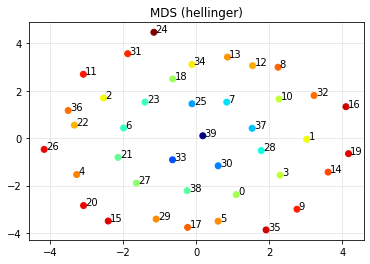

In [8]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features_mi.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types_mi.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)

emb_mi_random = FINE(rawdata, variable_types, random_grouping=True, plot=True)
EMBEDDINGS["Mutual Information Features\n(Random Grouping)"] = emb_mi_random

# 5) Spatial information

In [9]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [10]:
rawdata = df[["hhid", "dcode", "ezcode"]]

# construct community code from union, thana, district codes
rawdata["community_code"] = df["ucode"].astype(str) + "_" + \
                            df["tcode"].astype(str) + "_" + \
                            df["dcode"].astype(str)
rawdata["community_code"] = LabelEncoder().fit_transform(rawdata["community_code"])

variable_types = {
    "ucode": "discrete_categorical",
    "tcode": "discrete_categorical",
    "dcode": "discrete_categorical",
    "ezcode": "discrete_categorical"
}

In [11]:
# construct map from hhid to community code
HHID_COMMUNITY = {}
for index, row in rawdata.iterrows():
    HHID_COMMUNITY[row["hhid"]] = int(row["community_code"])

In [12]:
rawdata = rawdata[["dcode", "ezcode", "community_code"]]

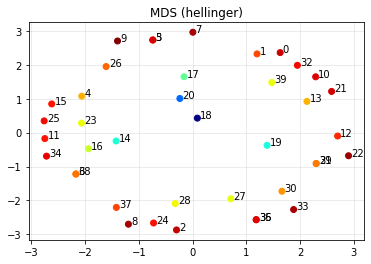

In [13]:
emb_spatial = FINE(rawdata, variable_types, plot=True)
EMBEDDINGS["Spatial Characteristics"] = emb_spatial

# 6) Adaptation options

In [14]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

keep = ["hhid", "o01"] + [f"o0{i}_1" for i in range(2, 9)] + ["o09"] + [f"o{i}" for i in range(10, 23)]
df = df[keep]
keep.remove("hhid")
df[keep] = df[keep].replace(2, 0)
df = df.fillna(-1)

In [15]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df2 = load_data(path)

keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
df2 = df2[keep]
keep.remove("hhid")
df2[keep] = df2[keep].replace(2, 0)
df2 = df2.fillna(-1)

In [16]:
df = df.merge(df2, on="hhid")

In [17]:
# insert community codes
community_codes = {"hhid":[], "community_code":[]}
for index, row in df.iterrows():
    hhid = row["hhid"]
    community_codes["hhid"].append(hhid)
    community_codes["community_code"].append(HHID_COMMUNITY[hhid])
    
community_codes = pd.DataFrame.from_dict(community_codes)

df = df.merge(community_codes, on="hhid")
df = df.drop(["hhid"], axis=1)

In [18]:
# define variable types
variable_types = {}
for col in df.columns:
    if col != "community_code":
        variable_types[col] = "binary"

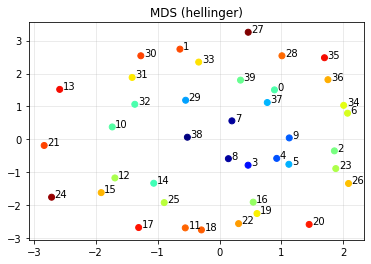

In [19]:
emb_adaptation = FINE(df, variable_types, plot=True)
EMBEDDINGS["Adaptation Options"] = emb_adaptation

# 7) Climatic shocks

In [20]:
filename = "012_mod_l.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

df[["l02"]] = df[["l02"]].replace(2, 0)
df = df[["hhid", "l01", "l02"]]

In [21]:
event_codes = {
    1: "floods",
    2: "flashfloods",
    3: "drought",
    4: "salinity_icnrease",
    5: "sea_level_rise",
    6: "frequent_rainfall",
    7: "temperature_rising",
    8: "temperature_variability",
    9: "soil_river_erosion",
    10: "tornado",
    11: "cyclone",
    12: "seasons_changing",
    13: "unknown_1",
    14: "unknown_2",
    15: "unknown_3"
}

In [22]:
events = {}
for c in event_codes:
    events[event_codes[c]] = {hhid:0 for hhid in df["hhid"].unique()}

for index, row in df.iterrows():
    hhid = row["hhid"]
    code = row["l01"]
    event = event_codes[code]
    events[event][hhid] = 1
    
    
events_df = {"hhid":[]}

for hhid in events["floods"]:
    events_df["hhid"].append(hhid)
    for e in events:
        if e not in events_df:
            events_df[e] = []
        events_df[e].append(events[e][hhid])

events_df = pd.DataFrame.from_dict(events_df)

community_codes = []
for index, row in events_df.iterrows():
    hhid = row["hhid"]
    community_codes.append(HHID_COMMUNITY[hhid])
    
events_df["community_code"] = community_codes

___

In [23]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [24]:
target_shocks = [6, 7, 10, 11, 12, 15, 17, 18]
shock_codes = {i:f"shock_{i}" for i in target_shocks}

In [25]:
shocks = {}
for c in shock_codes:
    shocks[shock_codes[c]] = {hhid:0 for hhid in df["hhid"].unique()}

for index, row in df.iterrows():
    hhid = row["hhid"]
    code = int(row["l2_01"])
    if code not in shock_codes:
        continue
    event = shock_codes[code]
    shocks[event][hhid] = 1
    
shocks_df = {"hhid":[]}
for hhid in shocks["shock_6"]:
    shocks_df["hhid"].append(hhid)
    for e in shocks:
        if e not in shocks_df:
            shocks_df[e] = []
        shocks_df[e].append(shocks[e][hhid])

shocks_df = pd.DataFrame.from_dict(shocks_df)

community_codes = []
for index, row in shocks_df.iterrows():
    hhid = row["hhid"]
    community_codes.append(HHID_COMMUNITY[hhid])
    
shocks_df["community_code"] = community_codes

In [26]:
new_events_rows = {"hhid":[], "community_code":[]}
for hhid in shocks_df["hhid"].unique():
    if hhid not in events_df["hhid"].unique():
        new_events_rows["hhid"].append(hhid)
        new_events_rows["community_code"].append(HHID_COMMUNITY[hhid])
        for col in events_df.columns:
            if col in ["hhid", "community_code"]:
                continue
            else:
                if col not in new_events_rows:
                    new_events_rows[col] = []
                new_events_rows[col].append(-1)
                
new_events_rows = pd.DataFrame.from_dict(new_events_rows)


new_shocks_rows = {"hhid":[], "community_code":[]}
for hhid in events_df["hhid"].unique():
    if hhid not in shocks_df["hhid"].unique():
        new_shocks_rows["hhid"].append(hhid)
        new_shocks_rows["community_code"].append(HHID_COMMUNITY[hhid])
        for col in shocks_df.columns:
            if col in ["hhid", "community_code"]:
                continue
            else:
                if col not in new_shocks_rows:
                    new_shocks_rows[col] = []
                new_shocks_rows[col].append(-1)
                
new_shocks_rows = pd.DataFrame.from_dict(new_shocks_rows)

In [27]:
events_df = pd.concat([events_df, new_events_rows])
shocks_df = pd.concat([shocks_df, new_shocks_rows])

In [28]:
merged = events_df.merge(shocks_df, on="hhid")
assert all(merged["community_code_x"] == merged["community_code_y"])
merged["community_code"] = merged["community_code_x"]
merged = merged.drop(["hhid", "community_code_x", "community_code_y"], axis=1)

In [29]:
# define variable types
variable_types = {}
for col in merged.columns:
    if col != "community_code":
        if col in events_df.columns:
            variable_types[col] = "binary"
        else:
            variable_types[col] = "discrete_ordered"

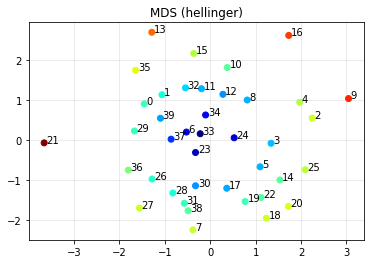

In [30]:
emb_all_shocks = FINE(merged, variable_types, plot=True)
EMBEDDINGS["Climatic Shocks"] = emb_all_shocks

# 8) Household characteristics

In [31]:
variable_types = {}
DICTS = {}

In [32]:
filename = "002_mod_b.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [33]:
# household size
size = dict(df.groupby("hhid").count()["mid"])

DICTS["household_size"] = size
variable_types["household_size"] = "discrete_ordered"

In [34]:
# gender household head
gender_household_head = {}
for index, row in df.iterrows():
    if row["b02"] == 1:
        hhid = row["hhid"]
        gender_household_head[hhid] = row["b01"] - 1
        
DICTS["gender_household_head"] = gender_household_head
variable_types["gender_household_head"] = "binary"

In [35]:
# age household head
age_household_head = {}
for index, row in df.iterrows():
    if row["b02"] == 1:
        hhid = row["hhid"]
        age_household_head[hhid] = row["b03"]

DICTS["age_household_head"] = age_household_head
variable_types["age_household_head"] = "discrete_ordered"

In [36]:
# highest education (years)
education_years = {
    99:0,
    0:2,
    66:1,
    67:1,
    1:2,
    2:2,
    3:2,
    4:2,
    5:2,
    6:2,
    7:2,
    8:2,
    9:2,
    10:3,
    12:3,
    22:3,
    33:3,
    15:4,
    16:4,
    17:5,
}

highest_education = {}
for index, row in df.iterrows():
    hhid = row["hhid"]
    education_level = row["b06"]
    years = education_years.get(education_level, -1)
    if hhid not in highest_education:
        highest_education[hhid] = years
    elif years > highest_education[hhid]:
        highest_education[hhid] = years
        
DICTS["highest_education"] = highest_education
variable_types["highest_education"] = "discrete_categorical"

        
madrasa = {}
for index, row in df.iterrows():
    hhid = row["hhid"]
    
    if hhid not in madrasa:
        madrasa[hhid] = int(row["b06"] == 68)
    else:
        madrasa[hhid] = max(madrasa[hhid], int(row["b06"] == 68))
        
DICTS["madrasa"] = madrasa
variable_types["madrasa"] = "binary"

In [37]:
agriculture_codes = [1, 4, 5, 6]

# primary, secondary occupations of household head in agriculture
occupation_1 = {}
occupation_2 = {}
for index, row in df.iterrows():
    if row["b02"] == 1:
        hhid = row["hhid"]
        occ_1, occ_2 = row["b08_1"], row["b08_2"]
        if not np.isnan(occ_1):
            occupation_1[hhid] = int(occ_1 in agriculture_codes)
        else:
            occupation_1[hhid] = -1
            
        if not np.isnan(occ_2):
            occupation_2[hhid] = int(occ_2 in agriculture_codes)
        else:
            occupation_2[hhid] = -1
            
DICTS["occupation_1"] = occupation_1
variable_types["occupation_1"] = "binary"

DICTS["occupation_2"] = occupation_2
variable_types["occupation_2"] = "binary"

In [38]:
# electricity access
filename = "011_mod_k.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

electricity_access = {}
for index, row in df.iterrows():
    hhid = row["hhid"]
    electricity_access[hhid] = row["k04"]
    
DICTS["electricity_access"] = electricity_access
variable_types["electricity_access"] = "discrete_categorical"

In [39]:
filename = "007_mod_h.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

# assets
assets = dict(df.groupby("hhid").sum()["h02"])
DICTS["assets"] = assets
variable_types["assets"] = "discrete_ordered"

# assets value
assets_value = dict(df.groupby("hhid").sum()["h06"])
DICTS["assets_value"] = assets_value
variable_types["assets_value"] = "discrete_ordered"

In [40]:
# livesstock quantity
filename = "004_mod_f1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

cattle_qty  = {}
goat_qty    = {}
pig_qty     = {}
chicken_qty = {}

for index, row in df.iterrows():
    hhid = row["hhid"]
    if hhid not in cattle_qty:
        cattle_qty[hhid] = 0
        goat_qty[hhid] = 0
        pig_qty[hhid] = 0
        chicken_qty[hhid] = 0
        
    animal_type = row["f101"]
    
    if animal_type == 1:
        cattle_qty[hhid] += row["f102"]
    elif animal_type == 2:
        goat_qty[hhid] += row["f102"]
    elif animal_type == 3:
        pig_qty[hhid] += row["f102"]
    elif animal_type == 4:
        chicken_qty[hhid] += row["f102"]
        
DICTS["cattle_qty"] = cattle_qty
variable_types["cattle_qty"] = "discrete_ordered"

DICTS["goat_qty"] = goat_qty
variable_types["goat_qty"] = "discrete_ordered"

DICTS["pig_qty"] = pig_qty
variable_types["pig_qty"] = "discrete_ordered"

DICTS["chicken_qty"] = chicken_qty
variable_types["chicken_qty"] = "discrete_ordered"

In [41]:
filename = "003_mod_c.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

# number of land
land = dict(df.groupby("hhid").count()["c101"])
DICTS["land_count"] = land
variable_types["land_count"] = "discrete_ordered"

# land value
land_value = dict(df.groupby("hhid").sum()["c109"])
DICTS["land_value"] = land_value
variable_types["land_value"] = "discrete_ordered"

In [42]:
# total expenditures
filename = "009_mod_i.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

total_expenditures = dict(df.groupby("hhid").sum()["i07"])

filename = "010_mod_j.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

non_food_expenditures = dict(df.groupby("hhid").sum()["j02_1"] * 0.46) # convert to roughly 14 days

for key, val in non_food_expenditures.items():
    if key not in total_expenditures:
        total_expenditures[key] = val
    else:
        total_expenditures[key] += val
        
DICTS["expenditure"] = total_expenditures
variable_types["expenditure"] = "discrete_ordered"

In [43]:
# income
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

income = dict(df.groupby("hhid").sum()["t14"])

DICTS["income"] = income
variable_types["income"] = "discrete_ordered"

In [44]:
def discretise_continuous_features(dictionaries, variable_types):
    
    new_labels = {}
    
    for feature_name, D in dictionaries.items():
        if variable_types[feature_name] == "discrete_ordered":
            vals = np.array([x for x in D.values() if not np.isnan(x) and x != -1])
            # determine p0 value yielding no more than 5 bins
            for p0 in [10**i for i in range(5, -20, -1)]:
                edges = bayesian_blocks(vals, fitness='events', p0=p0)
                if len(edges) <= 6:
                    break
            
            for k, v in D.items():
                if v != -1:
                    for i, e in enumerate(edges[1:]):
                        if v <= e:
                            D[k] = int(i)
                            break
                            
    return dictionaries

In [45]:
# discretize continuous features
DICTS = discretise_continuous_features(DICTS, variable_types)

In [46]:
# ensure all hhid present
all_hhids = set()
for feature_name, D in DICTS.items():
    for key in D:
        all_hhids.add(key)
        
for feature_name, D in DICTS.items():
    for hhid in all_hhids:
        if hhid not in D:
            D[hhid] = -1

In [47]:
merged = {f:[] for f in DICTS}
merged["hhid"] = []
merged["community_code"] = []

for hhid in all_hhids:
    merged["hhid"].append(hhid)
    merged["community_code"].append(HHID_COMMUNITY[hhid])
    for feature, D in DICTS.items():
        merged[feature].append(D[hhid])
        
merged = pd.DataFrame.from_dict(merged)

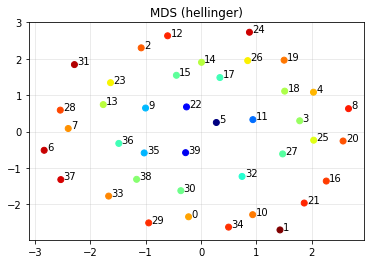

In [48]:
emb_hh_attributes = FINE(merged.drop(["hhid"], axis=1), variable_types, plot=True)
EMBEDDINGS["Household Characteristics"] = emb_hh_attributes

# Plot all embeddings

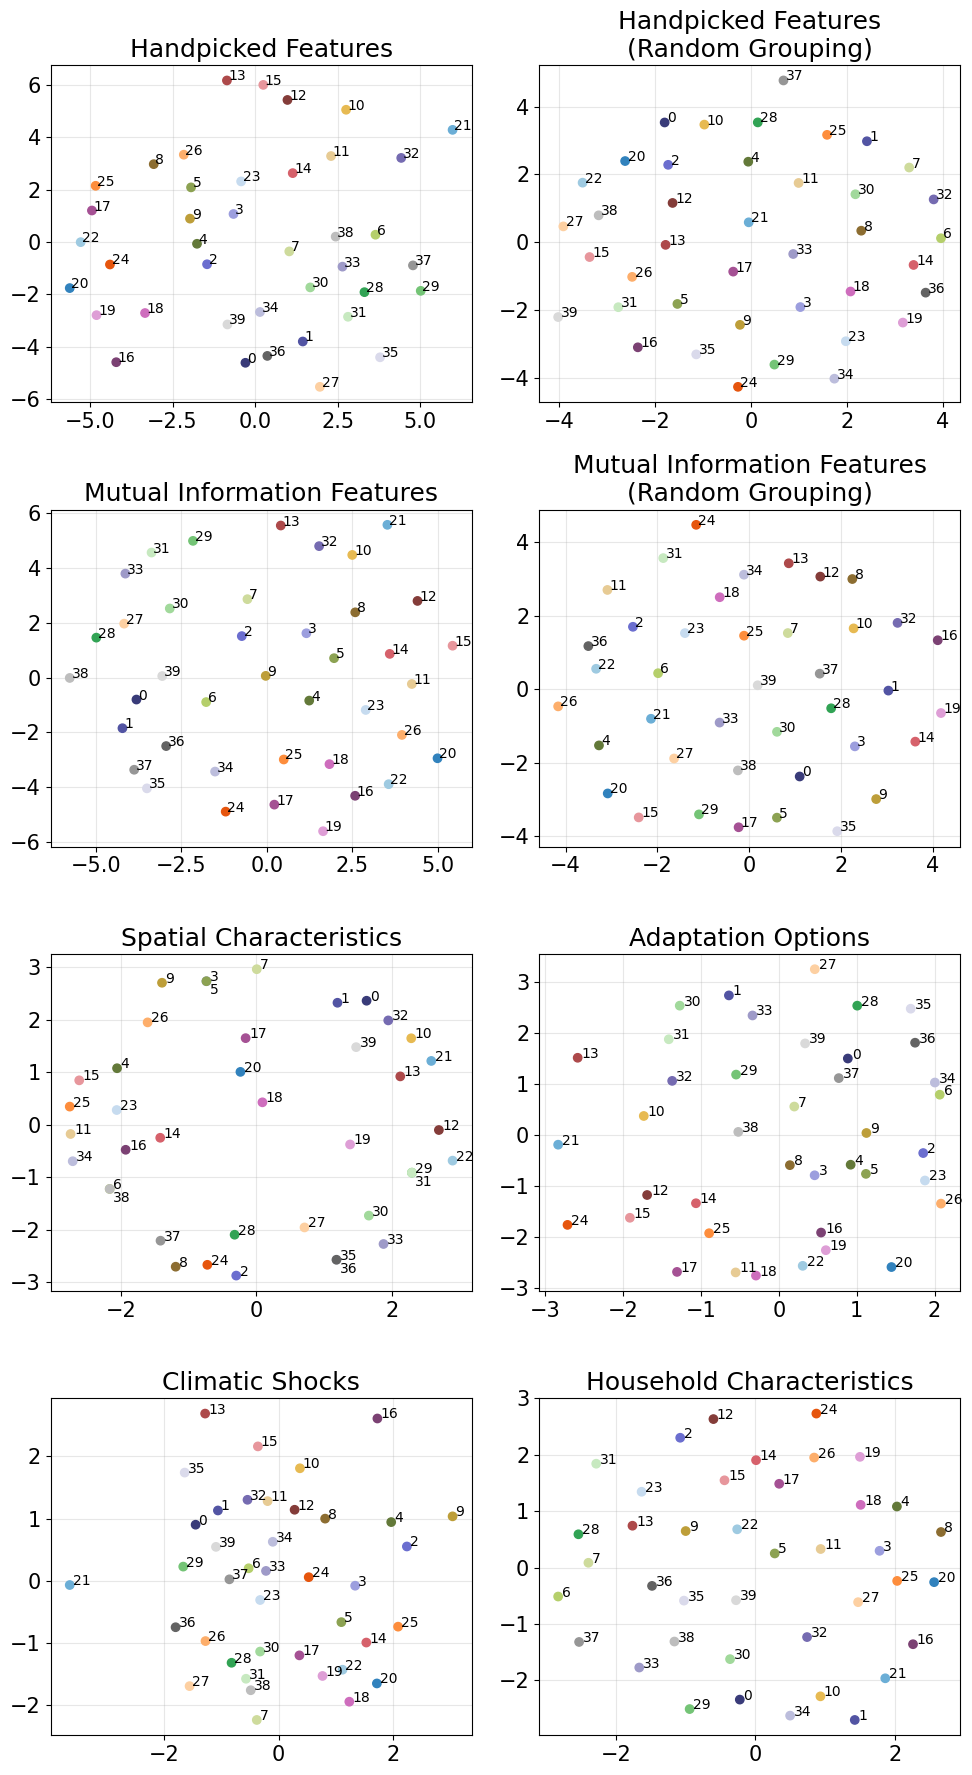

In [87]:
fig, axs = plt.subplots(4,2, figsize=(10, 18))

i = 0
j = 0

for title, em in EMBEDDINGS.items():
    
    x, y = em[:,0], em[:,1]
        
    cms = (np.average(em[:,0]), np.average(em[:,1]))
    dx = x - cms[0]
    dy = y - cms[1]
    t = np.sqrt(dx**2 + dy**2)
    t = (t - t.min()) * 100.0 / (t.max() - t.min())
    
    t = np.arange(20)
    
    axs[i][j].scatter(x[:20], y[:20], c=t[:20], cmap=cm.tab20b)
    axs[i][j].scatter(x[20:], y[20:], c=t[:20], cmap=cm.tab20c)

    D = euclidean_distances(em)
    for k in range(len(x)):
                
        indices = [i for i,z in enumerate(D[k]) if z < 0.1]
        
        if len(indices) > 1 and k == indices[1]:
            axs[i][j].annotate(k, (x[k]+0.05, y[k]-0.25), fontsize=10)
        else:
            axs[i][j].annotate(k, (x[k]+0.05, y[k]), fontsize=10)
        
    axs[i][j].set_title(title)
    
    # adjust subplot indices
    j += 1
    if j == 2:
        j = 0
        i += 1
        
fig.tight_layout()

plt.savefig("FINE_figures.pdf", bbox_inches="tight")